Convert the hdf5 files to images

In [ ]:
from haven import haven_utils as hu
Organ_Information = {"Breast":["TCGA-A7-A13E-01Z-00-DX1", 
                               "TCGA-A7-A13F-01Z-00-DX1", 
                               "TCGA-AR-A1AK-01Z-00-DX1", 
                               "TCGA-AR-A1AS-01Z-00-DX1", 
                               "TCGA-E2-A1B5-01Z-00-DX1", 
                               "TCGA-E2-A14V-01Z-00-DX1"], 
                     "Kidney":["TCGA-B0-5711-01Z-00-DX1", 
                               "TCGA-HE-7128-01Z-00-DX1", 
                               "TCGA-HE-7129-01Z-00-DX1", 
                               "TCGA-HE-7130-01Z-00-DX1", 
                               "TCGA-B0-5710-01Z-00-DX1", 
                               "TCGA-B0-5698-01Z-00-DX1"], 
                     "Liver":["TCGA-18-5592-01Z-00-DX1",
                              "TCGA-38-6178-01Z-00-DX1", 
                              "TCGA-49-4488-01Z-00-DX1", 
                              "TCGA-50-5931-01Z-00-DX1", 
                              "TCGA-21-5784-01Z-00-DX1", 
                              "TCGA-21-5786-01Z-00-DX1"], 
                     "Prostate":["TCGA-G9-6336-01Z-00-DX1", 
                                 "TCGA-G9-6348-01Z-00-DX1", 
                                 "TCGA-G9-6356-01Z-00-DX1", 
                                 "TCGA-G9-6363-01Z-00-DX1", 
                                 "TCGA-CH-5767-01Z-00-DX1", 
                                 "TCGA-G9-6362-01Z-00-DX1"], 
                     "Bladder":["TCGA-DK-A2I6-01A-01-TS1", 
                                "TCGA-G2-A2EK-01A-02-TSB"], 
                     "Colon":["TCGA-AY-A8YK-01A-01-TS1", 
                              "TCGA-NH-A8F7-01A-01-TS1"], 
                     "Stomach":["TCGA-KB-A93J-01A-01-TS1", 
                                "TCGA-RD-A8N9-01A-01-TS1"]}
hu.save_json('OrganInformation.json',Organ_Information)

In [12]:
import xml.etree.ElementTree as ET
import glob,os
import skimage.io as sio
import numpy as np
import shutil

def count_nuclei_file_name(file_name):
    tree = ET.parse(os.path.join('Annotations',file_name+'.xml'))
    root = tree.getroot()
    return len([0 for i in root.getiterator('Region')])

def count_nuclei_file_path(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    return len([0 for i in root.getiterator('Region')])

def save_to_folder(save_name, organ_dir, h5f, option):
    save_dir = os.path.join(organ_dir, option)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, save_name)
    print(save_path)
    v = h5f[save_name]
    points = np.flip(np.array(np.where(v[5])),axis = 0).transpose().tolist()
    sio.imsave(save_path+'_image.tif',v[:3].transpose(1,2,0))
    sio.imsave(save_path+'_obj.tif',v[3])
    sio.imsave(save_path+'_region.tif',v[4])
    hu.save_json(save_path+'_points.json', points)
    sio.imsave(save_path+'_bkgw.tif',v[6])
    sio.imsave(save_path+'_mask.tif',v[7])
    shutil.move(os.path.join('Annotations',save_name+'.xml'), save_path+'_annotation.xml')

In [10]:
import h5py
import skimage.io as sio
import glob,os
import pandas as pd

with h5py.File('../2D-Point-Segmentation/MoNuSegTrainingData/0_fold/dataset_nocrop.hdf5','r') as h5f:
    for organ, name_list in Organ_Information.items():
        organ_dir = os.path.join('MoNuSegTrainingData',organ)
        os.makedirs(organ_dir, exist_ok=True)
        d = dict()
        for data_name in name_list:
            d[data_name] = [count_nuclei_file_name(data_name)]
        df = pd.DataFrame.from_dict(d, orient='index')
        df.sort_values(by=0, ascending=False, inplace = True)
        sorted_name_list = list(df.index)
        
        for i in range(2):
            if len(sorted_name_list)>0:
                save_name = sorted_name_list.pop()
                save_to_folder(save_name, organ_dir, h5f, 'Test')
        for i in range(1):
            if len(sorted_name_list)>0:
                save_name = sorted_name_list.pop()
                save_to_folder(save_name, organ_dir, h5f, 'Validation')
        
        for i in range(3):
            if len(sorted_name_list)>0:
                save_name = sorted_name_list.pop()
                save_to_folder(save_name, organ_dir, h5f, 'Train')
                
#                 save_dir = os.path.join(organ_dir,'Test')
#                 os.makedirs(save_dir, exist_ok=True)
#                 save_path = os.path.join(save_dir, save_name)
#                 v = h5f[save_name]
#                 points = np.flip(np.array(np.where(v[5])),axis = 0).transpose().tolist()
#                 sio.imsave(save_path+'_image.tif',v[:3].transpose(1,2,0))
#                 sio.imsave(save_path+'_obj.tif',v[3])
#                 sio.imsave(save_path+'_region.tif',v[4])
#                 hu.save_json(save_path+'_points.json', points)
#                 sio.imsave(save_path+'_bkgw.tif',v[6])
#                 sio.imsave(save_path+'_mask.tif',v[7])
        
    #     for k,v in h5f.items():
        
#         test_im  = v[:3].transpose(1,2,0)
#         test_obj = v[3]
#         test_rlabel = v[4]
#         test_points = v[5]
#         test_bkg = v[6]
#         test_mask = v[7]
    
    

MoNuSegTrainingData/Breast/Test/TCGA-E2-A1B5-01Z-00-DX1
MoNuSegTrainingData/Breast/Test/TCGA-A7-A13F-01Z-00-DX1
MoNuSegTrainingData/Breast/Validation/TCGA-E2-A14V-01Z-00-DX1
MoNuSegTrainingData/Breast/Train/TCGA-AR-A1AS-01Z-00-DX1
MoNuSegTrainingData/Breast/Train/TCGA-AR-A1AK-01Z-00-DX1
MoNuSegTrainingData/Breast/Train/TCGA-A7-A13E-01Z-00-DX1
MoNuSegTrainingData/Kidney/Test/TCGA-HE-7128-01Z-00-DX1
MoNuSegTrainingData/Kidney/Test/TCGA-B0-5698-01Z-00-DX1
MoNuSegTrainingData/Kidney/Validation/TCGA-B0-5711-01Z-00-DX1
MoNuSegTrainingData/Kidney/Train/TCGA-B0-5710-01Z-00-DX1
MoNuSegTrainingData/Kidney/Train/TCGA-HE-7129-01Z-00-DX1
MoNuSegTrainingData/Kidney/Train/TCGA-HE-7130-01Z-00-DX1
MoNuSegTrainingData/Liver/Test/TCGA-38-6178-01Z-00-DX1
MoNuSegTrainingData/Liver/Test/TCGA-21-5786-01Z-00-DX1
MoNuSegTrainingData/Liver/Validation/TCGA-50-5931-01Z-00-DX1
MoNuSegTrainingData/Liver/Train/TCGA-18-5592-01Z-00-DX1
MoNuSegTrainingData/Liver/Train/TCGA-49-4488-01Z-00-DX1
MoNuSegTrainingData/Liver/T

In [16]:
counts = 0.0
for file_path in glob.glob('MoNuSegTrainingData/**/**/*.xml'):
    counts+=count_nuclei_file_path(file_path)
# for file_path in glob.glob('MoNuSegTrainingData/**/Validation/*.xml'):
#     counts+=count_nuclei_file_path(file_path)
print(counts)

21713.0


In [44]:
xml_path[:-15]

'MoNuSegTrainingData/Breast/Test/TCGA-E2-A1B5-01Z-00-DX1'

In [41]:
from skimage import draw
import xml.etree.ElementTree as ET
from skimage.morphology import skeletonize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def GetPolygonList(xmlfile_path):
    polygons = []
    tree = ET.parse(xmlfile_path)
    root = tree.getroot()
    for vertice in root.iter('Vertices'):
        polygon = []
        for vertex in vertice:
            polygon.append([float(vertex.get('X')),float(vertex.get('Y'))])
        polygons.append(np.array(polygon))
    return polygons

def GetPoints(polygons):
    nrow = 1000
    ncol = 1000
    mask = np.zeros((nrow,ncol))
    points = []
#     points = np.zeros_like(mask,dtype = bool)
    points_m = []
    for polygon in polygons:
        fill_row_coords, fill_col_coords = draw.polygon(polygon[:,1],polygon[:,0],(nrow,ncol))
        if len(fill_row_coords)>0:
            mask[fill_row_coords, fill_col_coords] = True
    #         import pdb
    #         pdb.set_trace()
            points_tmp = np.zeros((nrow,ncol))
            points_tmp[fill_row_coords, fill_col_coords] = True
            points_tmp = skeletonize(points_tmp)
#             points[points_tmp] = True
#             skeleton_row, skeleton_col = np.where(points_tmp)
            
#             points.append([skeleton_col.mean(),skeleton_row.mean()])
#             import pdb
#             pdb.set_trace()
            points+=np.flip(np.array(np.where(points_tmp)),axis = 0).transpose().tolist()
            points_m.append([fill_col_coords.mean(),fill_row_coords.mean()])
    return mask, points, points_m


# xml_path = 'MoNuSegTrainingData/Breast/Test/TCGA-E2-A1B5-01Z-00-DX1_annotation.xml'
for xml_path in glob.glob('MoNuSegTrainingData/**/**/*.xml'):
    save_path = xml_path[:-15]
    polygons = GetPolygonList(xml_path)
    mask, points, points_m = GetPoints(polygons)
    p_tmp = points.copy()
    p_tmp = np.array(p_tmp).round().astype(int)
    p_m_tmp = points_m.copy()
    p_m_tmp = np.array(p_m_tmp).round().astype(int)
    print(os.path.split(save_path)[-1])
    print('skeleton center:{}'.format(np.mean(mask[p_tmp[:,1],p_tmp[:,0]])))
#     print('skeleton center:{}'.format(np.mean(mask[points])))
    print('mass center:{}'.format(np.mean(mask[p_m_tmp[:,1],p_m_tmp[:,0]])))
    hu.save_json(save_path+'_points.json', points_m)
    sio.imsave(save_path+'_mask.tif',mask)
    
# polygon = polygons[0]

# nrow = 1000
# ncol = 1000
# binary_mask = np.zeros((nrow,ncol))
# smaller_x = polygon[:,0]
# smaller_y = polygon[:,1]
# fill_row_coords, fill_col_coords = draw.polygon(smaller_y,smaller_x,(nrow,ncol))
# binary_mask[fill_row_coords, fill_col_coords] = True
# skeleton = skeletonize(binary_mask)
# print(skeleton.sum())
# skeleton = skeletonize(skeleton)
# print(skeleton.sum())

TCGA-50-5931-01Z-00-DX1
skeleton center:1.0
mass center:1.0
TCGA-18-5592-01Z-00-DX1
skeleton center:1.0
mass center:0.9979166666666667
TCGA-21-5784-01Z-00-DX1
skeleton center:1.0
mass center:1.0
TCGA-49-4488-01Z-00-DX1
skeleton center:1.0
mass center:1.0
TCGA-38-6178-01Z-00-DX1
skeleton center:1.0
mass center:1.0
TCGA-21-5786-01Z-00-DX1
skeleton center:1.0
mass center:1.0
TCGA-NH-A8F7-01A-01-TS1
skeleton center:1.0
mass center:0.9917355371900827
TCGA-AY-A8YK-01A-01-TS1
skeleton center:1.0
mass center:1.0
TCGA-DK-A2I6-01A-01-TS1
skeleton center:1.0
mass center:1.0
TCGA-G2-A2EK-01A-02-TSB
skeleton center:1.0
mass center:1.0
TCGA-RD-A8N9-01A-01-TS1
skeleton center:1.0
mass center:1.0
TCGA-KB-A93J-01A-01-TS1
skeleton center:1.0
mass center:0.9992810927390366
TCGA-G9-6356-01Z-00-DX1
skeleton center:1.0
mass center:0.997737556561086
TCGA-G9-6336-01Z-00-DX1
skeleton center:1.0
mass center:1.0
TCGA-CH-5767-01Z-00-DX1
skeleton center:1.0
mass center:1.0
TCGA-G9-6362-01Z-00-DX1
skeleton center:1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


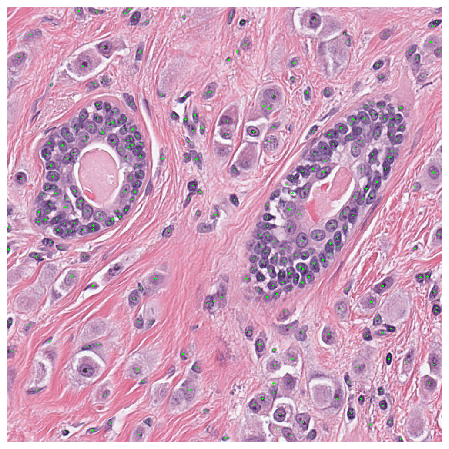

In [2]:
import cv2
from haven import haven_utils as hu
import numpy as np
import skimage.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

KEYPOINT_COLOR = (0, 1.0, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=2):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)
        
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

name_path = 'MoNuSegTrainingData/Breast/Test/TCGA-E2-A1B5-01Z-00-DX1'
points = hu.load_json(name_path+'_points.json')
image = sio.imread(name_path+'_image.tif')
mask = sio.imread(name_path+'_mask.tif')

vis_keypoints(image,points)
# vis_keypoints(mask,points)
# plt.figure()
# plt.imshow(mask)

In [3]:
from segmentation._watershed import watershed

points = np.array(points)
pl = np.zeros(image.shape[:2])
pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(1,len(points)+1)
bkg, dist = watershed(image,pl,method=True)

In [77]:
from skimage.filters import gaussian
from bayes_opt import BayesianOptimization
import glob,os
from segmentation._watershed import watershed

SMOOTH = 1e-6

def cross_entropy_numpy(outputs: np.array, labels: np.array):
    return np.mean(-labels*np.log(SMOOTH+outputs)-(1-labels)*np.log(SMOOTH+1-outputs))

def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.round().astype(bool)
    labels = labels.round().astype(bool)
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    return 1-iou

def black_box_function(compactness, alpha, sigma):
    loss = 0.0
    for xml_path in glob.glob('MoNuSegTrainingData/**/Train/*.xml'):
        name_path = xml_path[:-15]
        points = hu.load_json(name_path+'_points.json')
        image = sio.imread(name_path+'_norm.tif')
        mask = sio.imread(name_path+'_mask.tif')
        points = np.array(points)
        pl = np.zeros(image.shape[:2])
        pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(1,len(points)+1)
        image = gaussian(image,sigma, multichannel=True)
        _, dist = watershed(image, pl, compactness = compactness, method=True)
        prob = np.exp(-alpha*dist**2)
        loss += cross_entropy_numpy(prob, mask)+iou_numpy(prob,mask)
    return -loss

pbounds = {'compactness':(0,0.001), 'alpha':(0,10), 'sigma':(0,3)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)


optimizer.maximize(
    init_points=10,
    n_iter=500,
)

hu.save_json('objectness_params_0.json', optimizer.max)

|   iter    |  target   |   alpha   | compac... |   sigma   |
-------------------------------------------------------------
|  1        | -12.89    |  4.17     |  0.000720 |  0.000343 |
|  2        | -9.786    |  3.023    |  0.000146 |  0.277    |
|  3        | -9.082    |  1.863    |  0.000345 |  1.19     |
|  4        | -7.833    |  5.388    |  0.000419 |  2.056    |
|  5        | -8.989    |  2.045    |  0.000878 |  0.08216  |
|  6        | -8.447    |  6.705    |  0.000417 |  1.676    |
|  7        | -15.78    |  1.404    |  0.000198 |  2.402    |
|  8        | -8.713    |  9.683    |  0.000313 |  2.077    |
|  9        | -20.71    |  8.764    |  0.000894 |  0.2551   |
|  10       | -26.81    |  0.3905   |  0.000169 |  2.634    |
|  11       | -7.926    |  5.883    |  0.000417 |  1.915    |
|  12       | -7.949    |  5.686    |  0.000327 |  2.268    |
|  13       | -8.478    |  6.349    |  0.0      |  2.064    |
|  14       | -7.984    |  2.25     |  0.000363 |  0.6884   |
|  15   

|  80       | -7.746    |  4.44     |  0.000820 |  2.39     |
|  81       | -8.159    |  4.583    |  0.000969 |  1.707    |
|  82       | -7.749    |  4.467    |  0.000819 |  2.415    |
|  83       | -7.991    |  1.345    |  0.000938 |  0.02841  |
|  84       | -8.176    |  4.426    |  0.000442 |  2.424    |
|  85       | -11.28    |  1.768    |  0.000209 |  1.592    |
|  86       | -8.625    |  8.254    |  0.000119 |  1.675    |
|  87       | -8.865    |  4.127    |  0.000367 |  2.666    |
|  88       | -7.955    |  1.339    |  0.000772 |  0.3518   |
|  89       | -10.24    |  4.476    |  2.241e-0 |  2.404    |
|  90       | -7.776    |  4.597    |  0.000575 |  1.878    |
|  91       | -8.006    |  4.102    |  0.000728 |  2.664    |
|  92       | -8.153    |  7.926    |  0.000140 |  2.377    |
|  93       | -8.069    |  4.094    |  0.000684 |  2.658    |
|  94       | -9.987    |  3.9      |  3.529e-0 |  0.4646   |
|  95       | -7.838    |  2.338    |  0.000664 |  1.041    |
|  96   

|  161      | -7.793    |  4.408    |  0.000849 |  2.605    |
|  162      | -7.915    |  5.332    |  0.000619 |  1.899    |
|  163      | -7.96     |  2.255    |  0.000483 |  0.6857   |
|  164      | -8.732    |  9.777    |  0.00024  |  1.999    |
|  165      | -10.28    |  4.466    |  2.083e-0 |  2.412    |
|  166      | -55.97    |  0.007014 |  0.000121 |  1.473    |
|  167      | -7.836    |  4.582    |  0.000792 |  1.883    |
|  168      | -7.738    |  4.055    |  0.000747 |  1.861    |
|  169      | -8.252    |  4.58     |  0.000118 |  1.707    |
|  170      | -15.55    |  6.988    |  0.000307 |  0.3921   |
|  171      | -9.798    |  4.992    |  0.000217 |  0.7609   |
|  172      | -8.499    |  1.343    |  0.000137 |  0.02926  |
|  173      | -8.82     |  2.566    |  0.000691 |  2.207    |
|  174      | -10.56    |  2.343    |  0.000234 |  1.93     |
|  175      | -8.175    |  5.029    |  0.000892 |  1.795    |
|  176      | -8.0      |  5.394    |  0.000838 |  2.062    |
|  177  

|  242      | -8.004    |  5.641    |  0.000728 |  2.022    |
|  243      | -20.58    |  8.778    |  0.000847 |  0.1984   |
|  244      | -17.94    |  8.724    |  0.000148 |  0.05505  |
|  245      | -7.791    |  3.654    |  0.000559 |  1.521    |
|  246      | -8.026    |  4.583    |  0.000277 |  1.895    |
|  247      | -7.933    |  5.758    |  0.000922 |  2.542    |
|  248      | -10.41    |  2.059    |  0.000622 |  2.411    |
|  249      | -10.42    |  4.443    |  7.397e-0 |  2.392    |
|  250      | -7.925    |  4.31     |  0.000943 |  2.998    |
|  251      | -8.145    |  5.884    |  0.000681 |  1.91     |
|  252      | -7.82     |  5.392    |  0.000559 |  2.058    |
|  253      | -8.029    |  2.343    |  0.000416 |  1.035    |
|  254      | -7.981    |  7.545    |  0.000349 |  2.627    |
|  255      | -9.189    |  1.886    |  0.000654 |  1.661    |
|  256      | -8.916    |  4.621    |  0.000114 |  2.181    |
|  257      | -7.79     |  3.648    |  0.000564 |  1.521    |
|  258  

|  323      | -7.849    |  2.003    |  0.000719 |  0.8652   |
|  324      | -7.796    |  4.394    |  0.000915 |  2.008    |
|  325      | -8.587    |  5.642    |  0.0      |  2.016    |
|  326      | -8.91     |  6.448    |  0.000982 |  1.908    |
|  327      | -8.125    |  5.989    |  0.000279 |  2.509    |
|  328      | -16.35    |  0.583    |  0.000460 |  1.273    |
|  329      | -8.261    |  3.826    |  0.000405 |  2.112    |
|  330      | -8.195    |  6.926    |  0.000534 |  2.036    |
|  331      | -15.51    |  9.707    |  0.000840 |  0.9106   |
|  332      | -7.911    |  5.875    |  0.000383 |  2.391    |
|  333      | -7.849    |  5.64     |  0.000416 |  2.031    |
|  334      | -9.0      |  4.471    |  0.000191 |  2.416    |
|  335      | -8.352    |  4.388    |  0.000227 |  2.029    |
|  336      | -7.966    |  6.108    |  0.000788 |  2.389    |
|  337      | -8.103    |  4.275    |  0.000224 |  1.734    |
|  338      | -7.773    |  4.893    |  0.000868 |  2.35     |
|  339  

|  404      | -7.896    |  4.398    |  0.000434 |  2.008    |
|  405      | -9.695    |  1.004    |  5.169e-0 |  0.1974   |
|  406      | -11.13    |  3.347    |  0.000756 |  0.362    |
|  407      | -8.118    |  5.88     |  0.000255 |  2.392    |
|  408      | -8.144    |  4.388    |  0.000543 |  2.608    |
|  409      | -8.243    |  3.09     |  0.000933 |  1.026    |
|  410      | -8.364    |  4.422    |  0.000363 |  2.413    |
|  411      | -9.178    |  4.062    |  3.847e-0 |  1.855    |
|  412      | -17.86    |  9.144    |  0.000338 |  0.433    |
|  413      | -8.388    |  4.894    |  0.000255 |  2.345    |
|  414      | -9.757    |  3.233    |  0.000128 |  0.3844   |
|  415      | -8.117    |  5.876    |  0.001    |  2.396    |
|  416      | -7.851    |  5.648    |  0.000456 |  2.021    |
|  417      | -7.899    |  5.753    |  0.000881 |  2.544    |
|  418      | -7.866    |  4.576    |  0.000388 |  1.881    |
|  419      | -7.837    |  5.996    |  0.000664 |  2.511    |
|  420  

|  485      | -8.453    |  8.239    |  0.000767 |  2.626    |
|  486      | -8.627    |  3.04     |  0.000187 |  1.499    |
|  487      | -13.69    |  5.368    |  0.000243 |  0.2077   |
|  488      | -9.053    |  4.404    |  6.841e-0 |  2.024    |
|  489      | -8.2      |  3.378    |  0.000474 |  1.942    |
|  490      | -16.13    |  7.549    |  0.000246 |  0.387    |
|  491      | -8.17     |  4.717    |  0.000150 |  1.251    |
|  492      | -7.906    |  4.409    |  0.000692 |  2.592    |
|  493      | -8.027    |  4.58     |  0.000666 |  1.557    |
|  494      | -7.92     |  4.791    |  0.000282 |  1.727    |
|  495      | -7.761    |  4.054    |  0.000606 |  1.851    |
|  496      | -8.23     |  5.69     |  0.000158 |  2.157    |
|  497      | -9.227    |  9.664    |  0.000298 |  1.794    |
|  498      | -8.6      |  4.879    |  9.139e-0 |  2.003    |
|  499      | -8.642    |  9.735    |  0.000726 |  2.955    |
|  500      | -8.423    |  2.331    |  0.000200 |  1.028    |
|  501  

0.6101813080553057


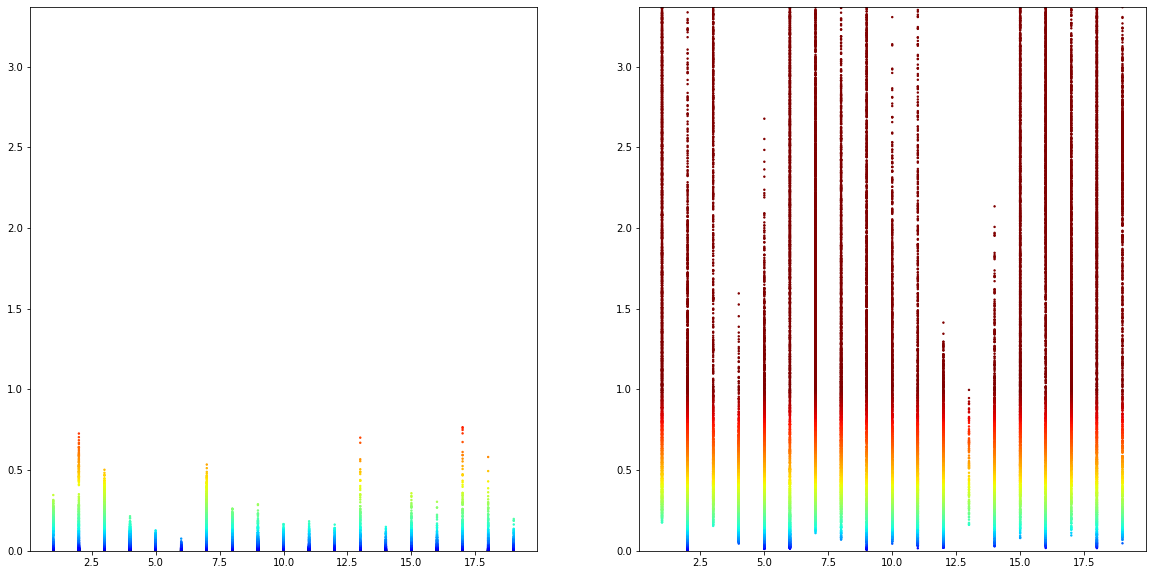

In [255]:
from skimage.segmentation import find_boundaries
from segmentation._watershed import watershed as watershed_o
from matplotlib import cm
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.segmentation import watershed

obj_params = hu.load_json('objectness_params_0.json')['params']

paths = glob.glob('MoNuSegTrainingData/**/Test/*.xml')
# name_path = 'MoNuSegTrainingData/Breast/Test/TCGA-E2-A1B5-01Z-00-DX1'
name_path = paths[0][:-15]
points = hu.load_json(name_path+'_points.json')
image = sio.imread(name_path+'_image.tif')
mask = sio.imread(name_path+'_mask.tif')

points = np.array(points)
pl = np.zeros(image.shape[:2])
pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(1,len(points)+1)
image = gaussian(image,obj_params['sigma'], multichannel=True)
bkg, dist = watershed_o(image, pl, compactness = obj_params['compactness'], method=True)

# bkg = watershed(np.zeros_like(mask), pl)

prob = np.exp(-obj_params['alpha']*dist**2)
print(1-iou_numpy(prob, mask))
# dist_m = np.mean(dist)
# dist_s = np.std(dist)
fig,axes = plt.subplots(1,2, figsize = (20,10))
for rlabel in np.unique(bkg):
    if rlabel<20:
        rmask = bkg==rlabel
    #     dist[rmask] = (dist[rmask]-np.mean(dist[rmask]))/np.std(dist[rmask])*dist_s+dist_m
        r_bkg = rmask&(~mask.astype(bool))
        r_fgd = rmask & mask.astype(bool)
        axes[0].scatter(np.array([rlabel for i in range(len(dist[r_fgd]))]), dist[r_fgd]**2,s=2, c=cm.jet(dist[r_fgd]))
        axes[0].set_ylim([0,dist[rmask].max()**2])
        axes[1].scatter(np.array([rlabel for i in range(len(dist[r_bkg]))]), dist[r_bkg]**2,s=2, c=cm.jet(dist[r_bkg]))
        axes[1].set_ylim([0,dist[rmask].max()**2])

# prob = np.exp(-obj_params['alpha']*dist**2)
# print(1- iou_numpy(prob, mask))
# fig,axes = plt.subplots(1,2,figsize = (20,10))
# axes[0].imshow(mask)
# axes[1].imshow(prob,cmap='jet')

In [192]:
rlabel

424

In [195]:
x.shape

NameError: name 'x' is not defined

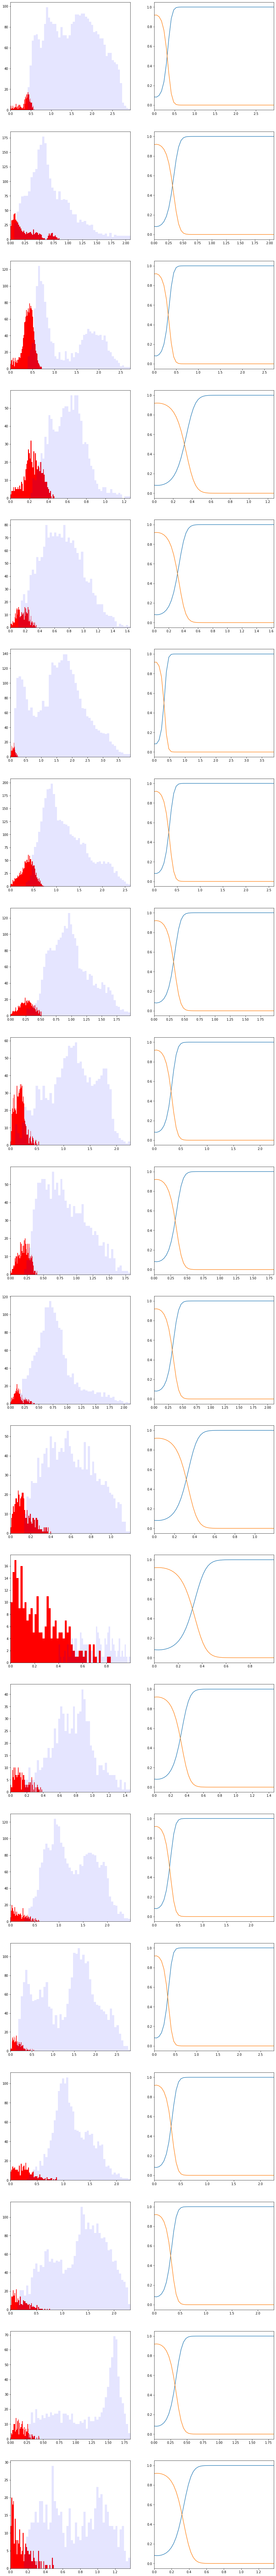

In [266]:
from sklearn.mixture import BayesianGaussianMixture

obj_params = hu.load_json('objectness_params_0.json')['params']

paths = glob.glob('MoNuSegTrainingData/**/Test/*.xml')
# name_path = 'MoNuSegTrainingData/Breast/Test/TCGA-E2-A1B5-01Z-00-DX1'
name_path = paths[0][:-15]
points = hu.load_json(name_path+'_points.json')
image = sio.imread(name_path+'_image.tif')
mask = sio.imread(name_path+'_mask.tif')

points = np.array(points)
pl = np.zeros(image.shape[:2])
pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(1,len(points)+1)
image = gaussian(image,obj_params['sigma'], multichannel=True)
bkg, dist = watershed_o(image, pl, compactness = obj_params['compactness'], method=True)

fig,axes = plt.subplots(20,2, figsize = (15,150))
for rlabel in np.unique(bkg):
    
    if rlabel<=20:
        rmask = bkg==rlabel
    #     dist[rmask] = (dist[rmask]-np.mean(dist[rmask]))/np.std(dist[rmask])*dist_s+dist_m
        r_bkg = rmask&(~mask.astype(bool))
        r_fgd = rmask & mask.astype(bool)

#     bgmm = BayesianGaussianMixture(n_init = 5,
#                                    max_iter = 200,
#                                    n_components=2, 
#                                    weight_concentration_prior= 0.1, 
#                                    mean_precision_prior= 10, mean_prior = [0.3])

#     dbgmm = bgmm.fit(dist[rmask][:,None])
#     prob_prop = dbgmm.predict_proba(dist[rmask][:,None])
# #         import pdb
# #         pdb.set_trace()
#     f_index = dbgmm.predict_proba(np.array([[0.2]])).argmax()
#     dist[rmask] = prob_prop[:,f_index]
        
        
        
        x = np.linspace(0,dist[rmask].max())
        axes[rlabel.astype(int)-1,1].plot(x, dpgmm.predict_proba(x[:,None]))
        axes[rlabel.astype(int)-1,1].set_xlim([0,dist[rmask].max()])
        axes[rlabel.astype(int)-1,0].hist(dist[r_fgd],50, color = 'red')
        axes[rlabel.astype(int)-1,0].hist(dist[r_bkg],50, color = 'blue', alpha = 0.1)
        axes[rlabel.astype(int)-1,0].set_xlim([0,dist[rmask].max()])
# #         import pdb
# #         pdb.set_trace()
#         axes[rlabel.astype(int)-20,1].hist(dist[rmask][prob_prop==0],50, color = 'red')
#         axes[rlabel.astype(int)-20,1].hist(dist[rmask][prob_prop==1],50, color = 'blue')
#         axes[rlabel.astype(int)-20,1].set_xlim([0,dist[rmask].max()])

0.4101590873283092

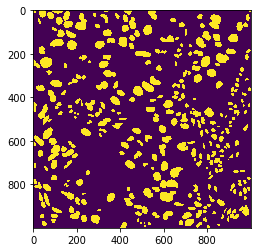

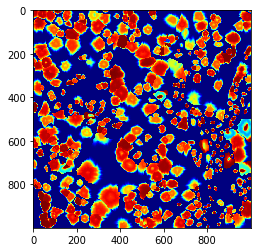

In [253]:
# plt.imshow(iou1-dist>0.5,cmap='jet')
plt.imshow(mask)
plt.figure()
plt.imshow(dist, cmap='jet')
1-iou_numpy(dist>0.8, mask)
# dist.max()

In [149]:
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.segmentation import find_boundaries


points = hu.load_json(name_path+'_points.json')
image = sio.imread(name_path+'_image.tif')

out = gradient(image[...,0],disk(5))

points = np.array(points)
pl = np.zeros(image.shape[:2])
pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(2,len(points)+2)

bkg = watershed(np.zeros_like(out), pl)
bkg = find_boundaries(bkg)

pl[bkg] = 1

labels = watershed(out, pl)

(array([ 198.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1012.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

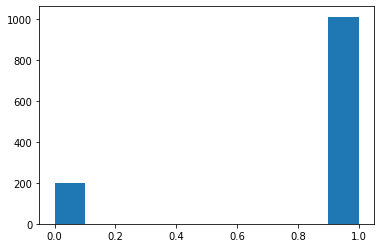

In [223]:
plt.hist(prob_prop)

In [82]:
def black_box_function_test(compactness, alpha, sigma):
#     loss = 0.0
    cross_entropy = []
    iou = []
    for xml_path in glob.glob('MoNuSegTrainingData/**/Validation/*.xml'):
        name_path = xml_path[:-15]
        points = hu.load_json(name_path+'_points.json')
        image = sio.imread(name_path+'_norm.tif')
        mask = sio.imread(name_path+'_mask.tif')
        points = np.array(points)
        pl = np.zeros(image.shape[:2])
        pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(1,len(points)+1)
        image = gaussian(image,sigma, multichannel=True)
        _, dist = watershed(image, pl, compactness = compactness, method=True)
        prob = np.exp(-alpha*dist**2)
#         loss += cross_entropy_numpy(prob, mask)+iou_numpy(prob,mask)
        cross_entropy.append(cross_entropy_numpy(prob,mask))
        iou.append(1-iou_numpy(prob,mask))
    return np.mean(cross_entropy), np.mean(iou)

obj_params_0 = hu.load_json('objectness_params_0.json')['params']
obj_params = hu.load_json('objectness_params.json')['params']

ce_0, iou_0 = black_box_function_test(**obj_params_0)

In [83]:
iou_0

0.6051517042943286

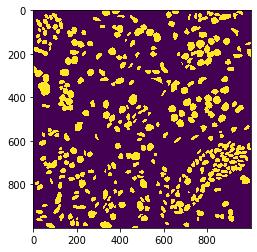

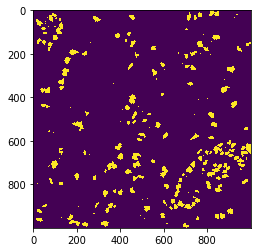

In [169]:
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(labels>1)

# Generate the objectness using the Bayesian optimized hyperparameter



## Check if the point labels lie inside the nuclei

Instead of using the mass center weight, we use the skeleton centers to ensure that the point label always lies inside the nuclei. This step is trying to prove that we have the right skeleton centers.

In [39]:
import glob,os
from haven import haven_utils as hu
import skimage.io as sio
import numpy as np

for points_file in glob.glob('MoNuSegTrainingData/**/**/*_points.json'):
    points = np.array(hu.load_json(points_file)).round().astype(int)
#     np.array(p_tmp).round().astype(int)
    file_dir, file_name = os.path.split(points_file)
    data_name = file_name[:-12]
    mask = sio.imread(os.path.join(file_dir,data_name+"_mask.tif"))
    print(data_name+":{}".format(np.mean(mask[points[:,1],points[:,0]])))

TCGA-50-5931-01Z-00-DX1:1.0
TCGA-18-5592-01Z-00-DX1:0.9979166666666667
TCGA-21-5784-01Z-00-DX1:1.0
TCGA-18-5592-01Z-00-DX1:1.0
TCGA-49-4488-01Z-00-DX1:1.0
TCGA-50-5931-01Z-00-DX1:1.0
TCGA-38-6178-01Z-00-DX1:1.0
TCGA-21-5786-01Z-00-DX1:1.0
TCGA-AY-A8YK-01A-01-TS1:1.0
TCGA-NH-A8F7-01A-01-TS1:1.0
TCGA-DK-A2I6-01A-01-TS1:1.0
TCGA-G2-A2EK-01A-02-TSB:1.0
TCGA-RD-A8N9-01A-01-TS1:1.0
TCGA-KB-A93J-01A-01-TS1:1.0
TCGA-G9-6356-01Z-00-DX1:1.0
TCGA-G9-6336-01Z-00-DX1:1.0
TCGA-CH-5767-01Z-00-DX1:1.0
TCGA-G9-6336-01Z-00-DX1:1.0
TCGA-G9-6362-01Z-00-DX1:1.0
TCGA-G9-6363-01Z-00-DX1:1.0
TCGA-G9-6356-01Z-00-DX1:0.997737556561086
TCGA-G9-6348-01Z-00-DX1:1.0
TCGA-B0-5711-01Z-00-DX1:1.0
TCGA-B0-5710-01Z-00-DX1:1.0
TCGA-HE-7129-01Z-00-DX1:1.0
TCGA-HE-7130-01Z-00-DX1:1.0
TCGA-HE-7128-01Z-00-DX1:1.0
TCGA-B0-5698-01Z-00-DX1:1.0
TCGA-E2-A14V-01Z-00-DX1:1.0
TCGA-AR-A1AK-01Z-00-DX1:1.0
TCGA-A7-A13E-01Z-00-DX1:1.0
TCGA-AR-A1AS-01Z-00-DX1:1.0
TCGA-E2-A1B5-01Z-00-DX1:1.0
TCGA-A7-A13F-01Z-00-DX1:1.0


## Color Normalization

According to the paper[1], it will help if we preprocess the image by doing the color normalization[2]. Also, according to [1], image `TCGA-G9-6356-01Z-00-DX1` is recommended to be the target image

[1] N. Kumar, R. Verma, S. Sharma, S. Bhargava, A. Vahadane and A. Sethi, "A Dataset and a Technique for Generalized Nuclear Segmentation for Computational Pathology," in IEEE Transactions on Medical Imaging, vol. 36, no. 7, pp. 1550-1560, July 2017, doi: 10.1109/TMI.2017.2677499.

[2] A. Vahadane et al., "Structure-preserved color normalization for histological images," 2015 IEEE 12th International Symposium on Biomedical Imaging (ISBI), New York, NY, 2015, pp. 1012-1015, doi: 10.1109/ISBI.2015.7164042.

In [75]:
import sys
sys.path.append('./Stain_Normalization/')
from Stain_Normalization import stainNorm_Vahadane
import shutil

target_image_file = "MoNuSegTrainingData/Prostate/Test/TCGA-G9-6356-01Z-00-DX1_image.tif"
target_image = sio.imread(target_image_file)

sources = glob.glob('MoNuSegTrainingData/**/**/*_image.tif')

for source_file in sources:
    file_dir, file_name = os.path.split(source_file)
    data_name = file_name[:-10]
    source_image = sio.imread(source_file)

    n = stainNorm_Vahadane.Normalizer()
    n.fit(target_image)
    normalized = n.transform(source_image)
    
#     os.remove(os.path.join(file_dir, data_name+'norm.tif'))
    sio.imsave(os.path.join(file_dir, data_name+'_norm.tif'), normalized)
# fig,axes = plt.subplots(1,3,figsize = (30,10))
# axes[0].imshow(target_image)
# axes[1].imshow(source_image)
# axes[2].imshow(normalized)
# axes[0].set_title('Target Image')
# axes[1].set_title('Source Image')
# axes[2].set_title('Normalized Image')

## Load the Bayesian optimized hyper-parameter and regenerate the objectness

The Bayesian optimized hyper-parameter is saved in `objectness_params_0.json`. Load it to generate the objectness.

In [51]:
SMOOTH = 1e-6

def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.round().astype(bool)
    labels = labels.round().astype(bool)
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    return iou

In [86]:
from skimage.filters import gaussian
from skimage.segmentation import find_boundaries
from skimage.segmentation import watershed
from segmentation._watershed import watershed as watershed_o

obj_params = hu.load_json('objectness_params_0.json')['params']

paths = glob.glob('MoNuSegTrainingData/**/Test/*.xml')
# name_path = 'MoNuSegTrainingData/Breast/Test/TCGA-E2-A1B5-01Z-00-DX1'

scores = []
for file_path in paths:
    name_path = file_path[:-15]
    points = hu.load_json(name_path+'_points.json')
    image = sio.imread(name_path+'_norm.tif')
    mask = sio.imread(name_path+'_mask.tif')

    points = np.array(points)
    pl = np.zeros(image.shape[:2])
    pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(1,len(points)+1)
    image = gaussian(image,obj_params['sigma'], multichannel=True)
    bkg, dist = watershed_o(image, pl, compactness = obj_params['compactness'], method=True)
    bkg_ = watershed(np.zeros_like(mask), pl)
    bkg = find_boundaries(bkg)
    bkg_ = find_boundaries(bkg_)
    prob = np.exp(-obj_params['alpha']*dist**2)
    prob[bkg] = 0
    sio.imsave(name_path+'_obj.tif',prob)
    sio.imsave(name_path+'_bkgw.tif',bkg.astype(float))
    sio.imsave(name_path+'_bkg.tif',bkg_.astype(float))
    scores.append(iou_numpy(prob, mask))
print(np.mean(scores))

0.3634880525931882


array([False,  True])

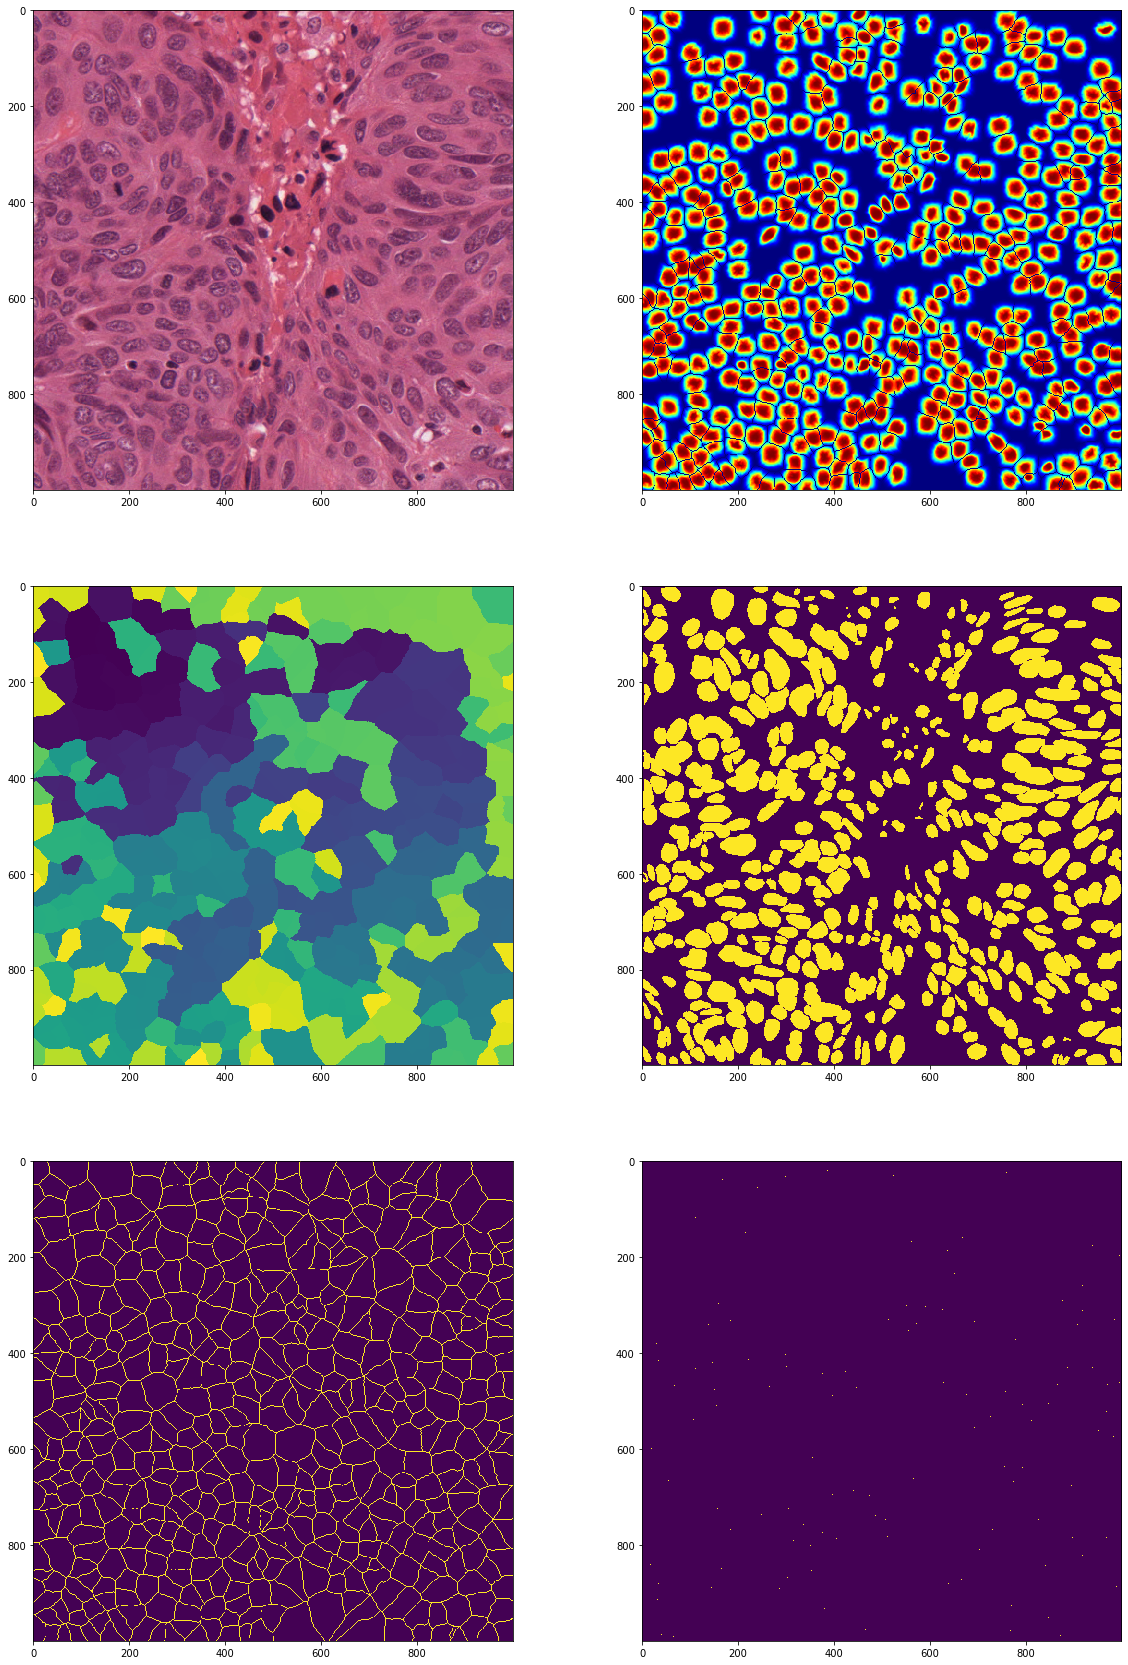

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,axes = plt.subplots(3,2,figsize = (20,30))
axes[0,0].imshow(test_im)
axes[0,1].imshow(test_obj,cmap='jet')
axes[1,0].imshow(test_rlabel)
axes[2,1].imshow(test_points)
axes[2,0].imshow(test_bkg)
axes[1,1].imshow(test_mask)